<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/LSTM_302a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 302a
Start with LSTM 201 and modify it to use our updated code infrastructure.

In [2]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='LSTM302a'   # load not save!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=1
K=4
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=96
DROP=0.5
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [5]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    rnn1_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP) )#bi
    rnn2_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) )#bi
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    mlp.add(dense2_layer)
    mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

Partition sequences

In [6]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Cross validation

In [7]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [8]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
#print ("Data prep")
#X_train=tools.make_frequencies(K,X_train)

Load data from files.
Ready: train_set
Data reshape


In [9]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          4112      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 192)         86784     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 192)               221952    
_________________________________________________________________
dense (Dense)                (None, 96)                18528     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_____________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 89s 160ms/step - loss: 0.6092 - accuracy: 0.6784 - val_loss: 0.5783 - val_accuracy: 0.7089


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 2/100
453/453 [==============================] - 69s 153ms/step - loss: 0.5889 - accuracy: 0.6993 - val_loss: 0.5682 - val_accuracy: 0.7337


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 3/100
453/453 [==============================] - 69s 153ms/step - loss: 0.5988 - accuracy: 0.6910 - val_loss: 0.5648 - val_accuracy: 0.7169
Epoch 4/100
453/453 [==============================] - 70s 155ms/step - loss: 0.5661 - accuracy: 0.7100 - val_loss: 0.5706 - val_accuracy: 0.7083
Epoch 5/100
453/453 [==============================] - 70s 154ms/step - loss: 0.5762 - accuracy: 0.7013 - val_loss: 0.5292 - val_accuracy: 0.7436


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 6/100
453/453 [==============================] - 70s 154ms/step - loss: 0.5336 - accuracy: 0.7447 - val_loss: 0.5474 - val_accuracy: 0.7120
Epoch 7/100
453/453 [==============================] - 70s 154ms/step - loss: 0.5068 - accuracy: 0.7597 - val_loss: 0.4154 - val_accuracy: 0.8200


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 8/100
453/453 [==============================] - 70s 154ms/step - loss: 0.5955 - accuracy: 0.6890 - val_loss: 0.5577 - val_accuracy: 0.7138
Epoch 9/100
453/453 [==============================] - 70s 154ms/step - loss: 0.4756 - accuracy: 0.7876 - val_loss: 0.4189 - val_accuracy: 0.8125
Epoch 10/100
453/453 [==============================] - 70s 154ms/step - loss: 0.4219 - accuracy: 0.8177 - val_loss: 0.4978 - val_accuracy: 0.7865
Epoch 11/100
453/453 [==============================] - 69s 153ms/step - loss: 0.4514 - accuracy: 0.7954 - val_loss: 0.4671 - val_accuracy: 0.8287


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 12/100
453/453 [==============================] - 70s 154ms/step - loss: 0.4661 - accuracy: 0.7978 - val_loss: 0.3663 - val_accuracy: 0.8504


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 13/100
453/453 [==============================] - 70s 155ms/step - loss: 0.4073 - accuracy: 0.8278 - val_loss: 0.3599 - val_accuracy: 0.8473
Epoch 14/100
453/453 [==============================] - 70s 154ms/step - loss: 0.3943 - accuracy: 0.8334 - val_loss: 0.3303 - val_accuracy: 0.8647


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 15/100
453/453 [==============================] - 70s 154ms/step - loss: 0.3766 - accuracy: 0.8387 - val_loss: 0.3245 - val_accuracy: 0.8653


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 16/100
453/453 [==============================] - 70s 154ms/step - loss: 0.3535 - accuracy: 0.8520 - val_loss: 0.3195 - val_accuracy: 0.8678


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 17/100
453/453 [==============================] - 70s 155ms/step - loss: 0.3650 - accuracy: 0.8459 - val_loss: 0.3715 - val_accuracy: 0.8448
Epoch 18/100
453/453 [==============================] - 70s 154ms/step - loss: 0.3563 - accuracy: 0.8432 - val_loss: 0.3054 - val_accuracy: 0.8752


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 19/100
453/453 [==============================] - 69s 152ms/step - loss: 0.3895 - accuracy: 0.8270 - val_loss: 0.6180 - val_accuracy: 0.6698
Epoch 20/100
453/453 [==============================] - 70s 155ms/step - loss: 0.5958 - accuracy: 0.6921 - val_loss: 0.5361 - val_accuracy: 0.7331
Epoch 21/100
453/453 [==============================] - 70s 154ms/step - loss: 0.5412 - accuracy: 0.7326 - val_loss: 0.3993 - val_accuracy: 0.8237
Epoch 22/100
453/453 [==============================] - 70s 154ms/step - loss: 0.4153 - accuracy: 0.8235 - val_loss: 0.3452 - val_accuracy: 0.8603
Epoch 23/100
453/453 [==============================] - 70s 154ms/step - loss: 0.3922 - accuracy: 0.8349 - val_loss: 0.3375 - val_accuracy: 0.8616
Epoch 24/100
453/453 [==============================] - 71s 158ms/step - loss: 0.3711 - accuracy: 0.8423 - val_loss: 0.3197 - val_accuracy: 0.8641
Epoch 25/100
453/453 [==============================] - 70s 155ms/step - loss: 0.3738 - accuracy: 0.8389 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 43/100
453/453 [==============================] - 71s 156ms/step - loss: 0.3283 - accuracy: 0.8684 - val_loss: 0.3086 - val_accuracy: 0.8740
Epoch 44/100
453/453 [==============================] - 70s 155ms/step - loss: 0.3298 - accuracy: 0.8616 - val_loss: 0.3108 - val_accuracy: 0.8659
Epoch 45/100
453/453 [==============================] - 71s 156ms/step - loss: 0.3219 - accuracy: 0.8628 - val_loss: 0.3091 - val_accuracy: 0.8715
Epoch 46/100
453/453 [==============================] - 70s 155ms/step - loss: 0.3220 - accuracy: 0.8664 - val_loss: 0.3146 - val_accuracy: 0.8746
Epoch 47/100
453/453 [==============================] - 71s 157ms/step - loss: 0.3208 - accuracy: 0.8663 - val_loss: 0.3260 - val_accuracy: 0.8659
Epoch 48/100
453/453 [==============================] - 70s 155ms/step - loss: 0.3179 - accuracy: 0.8675 - val_loss: 0.3358 - val_accuracy: 0.8510
Epoch 49/100
453/453 [==============================] - 71s 157ms/step - loss: 0.3241 - accuracy: 0.8653 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 50/100
453/453 [==============================] - 71s 156ms/step - loss: 0.3103 - accuracy: 0.8726 - val_loss: 0.3118 - val_accuracy: 0.8814


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 51/100
453/453 [==============================] - 71s 156ms/step - loss: 0.3098 - accuracy: 0.8734 - val_loss: 0.3329 - val_accuracy: 0.8547
Epoch 52/100
453/453 [==============================] - 71s 156ms/step - loss: 0.2949 - accuracy: 0.8811 - val_loss: 0.3010 - val_accuracy: 0.8827


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 53/100
453/453 [==============================] - 71s 156ms/step - loss: 0.3165 - accuracy: 0.8681 - val_loss: 0.3166 - val_accuracy: 0.8709
Epoch 54/100
453/453 [==============================] - 71s 158ms/step - loss: 0.3064 - accuracy: 0.8776 - val_loss: 0.2974 - val_accuracy: 0.8808
Epoch 55/100
453/453 [==============================] - 71s 156ms/step - loss: 0.3012 - accuracy: 0.8797 - val_loss: 0.3079 - val_accuracy: 0.8802
Epoch 56/100
453/453 [==============================] - 71s 157ms/step - loss: 0.3022 - accuracy: 0.8812 - val_loss: 0.3099 - val_accuracy: 0.8802
Epoch 57/100
453/453 [==============================] - 71s 156ms/step - loss: 0.2913 - accuracy: 0.8851 - val_loss: 0.3179 - val_accuracy: 0.8684
Epoch 58/100
453/453 [==============================] - 71s 156ms/step - loss: 0.2817 - accuracy: 0.8871 - val_loss: 0.3103 - val_accuracy: 0.8777
Epoch 59/100
453/453 [==============================] - 71s 156ms/step - loss: 0.2907 - accuracy: 0.8805 - val_loss: 0

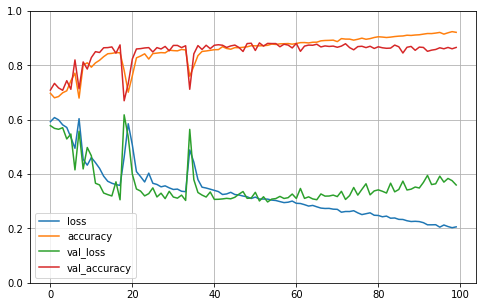

accuracy: 88.27%

1-way Cross Validation mean 88.27% (+/- 0.00%)
Done


In [10]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")